# Notebook for testing and debugging Sequential Monte Carlo algorithms

In [29]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import seaborn as sns

from approxmh.utilities import *
from approxmh.samplers import *
from approxmh.distributions import Banana, Funnel, create_gaussian_mixture, create_gaussian_lattice, create_random_gaussian_mixture, get_mode_coverage
from approxmh.distribution_metrics import *
from approxmh.sequential_mcmc import ULAKernel, run_annealed_importance_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cuda


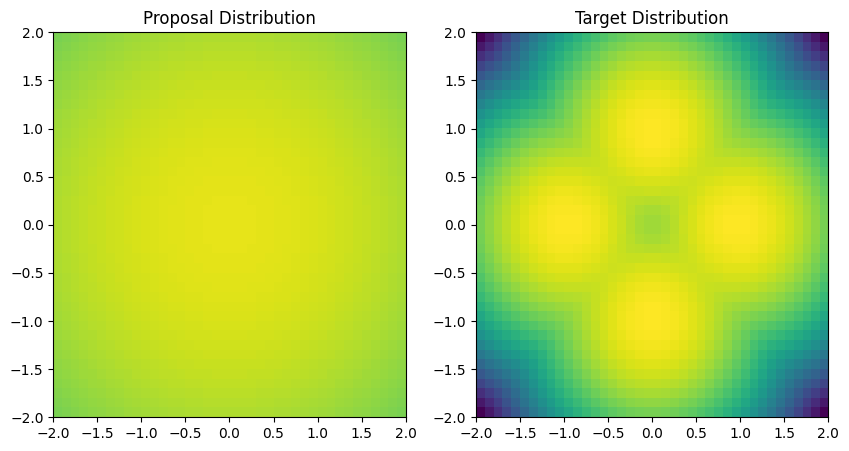

In [82]:
D = 2
proposal = torch.distributions.MultivariateNormal(torch.zeros(D), torch.eye(D))
target = create_gaussian_mixture(
    means = torch.tensor([[-1., 0.], [1., 0.], [0., -1.], [0., 1.]]),
    cov_matricies = 0.1 * torch.eye(2)
)

xlim=(-2, 2)
ylim = (-2, 2)
d = 40

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
img1 = plot_2d_torch_function(axs[0], proposal.log_prob, xlim, ylim, d)
axs[0].set_title('Proposal Distribution')
img2 = plot_2d_torch_function(axs[1], target.log_prob, xlim, ylim, d)
axs[1].set_title('Target Distribution')
vmin1, vmax1 = img1.get_clim()
vmin2, vmax2 = img2.get_clim()
clim = (min(vmin1, vmin2), max(vmax1, vmax2))
img1.set_clim(*clim)
img2.set_clim(*clim)

Weight Mean : 1.01072
Weight Variance : 1.42549
tensor([-1.1282, -0.2592, -2.6816,  ...,  0.4928,  0.9126, -0.6973])


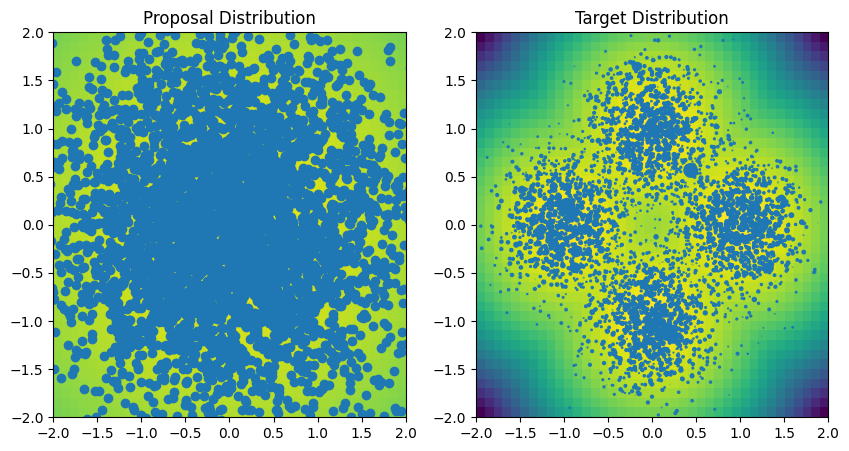

In [216]:
# ULA parameters
time_step = 0.05
# AIS parameters
n_steps = 10
n_particles = 4000
transition_kernel = lambda distr: ULAKernel(distr, time_step)

log_weights, target_samples = run_annealed_importance_sampling(proposal, target, n_steps, n_particles, transition_kernel)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

img1 = plot_2d_torch_function(axs[0], proposal.log_prob, xlim, ylim, d)
axs[0].scatter(*pl(proposal.sample((n_particles,))))
axs[0].set_title('Proposal Distribution')

img2 = plot_2d_torch_function(axs[1], target.log_prob, xlim, ylim, d)
axs[1].scatter(*pl(target_samples), s=4*log_weights.detach().exp().cpu())
axs[1].set_title('Target Distribution')

for ax in axs:
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

vmin1, vmax1 = img1.get_clim()
vmin2, vmax2 = img2.get_clim()
clim = (min(vmin1, vmin2), max(vmax1, vmax2))
img1.set_clim(*clim)
img2.set_clim(*clim)

average_weight = log_weights.exp().sum() / n_particles
weight_variance = torch.var(log_weights.exp())
print(f'Weight Mean : {average_weight:0.5f}')
print(f'Weight Variance : {weight_variance:0.5f}')
print(log_weights)

Text(0.5, 1.0, 'Distribution of AIS Importance Weights')

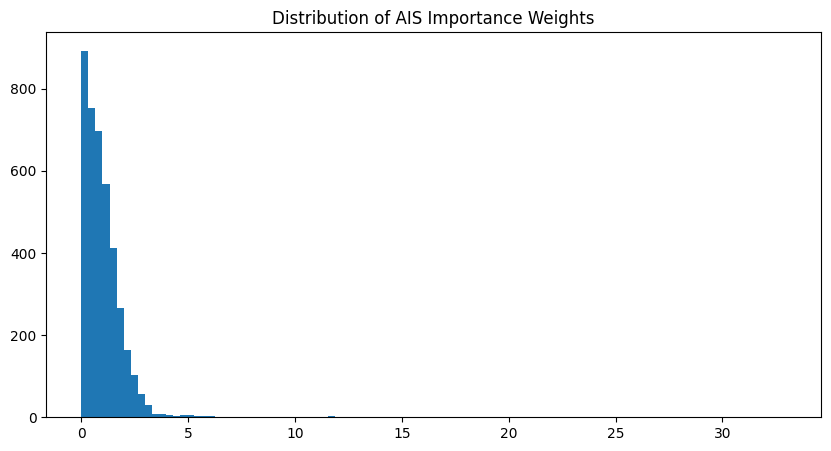

In [217]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.hist(to_numpy(log_weights.exp()), bins=100)
ax.set_title('Distribution of AIS Importance Weights')

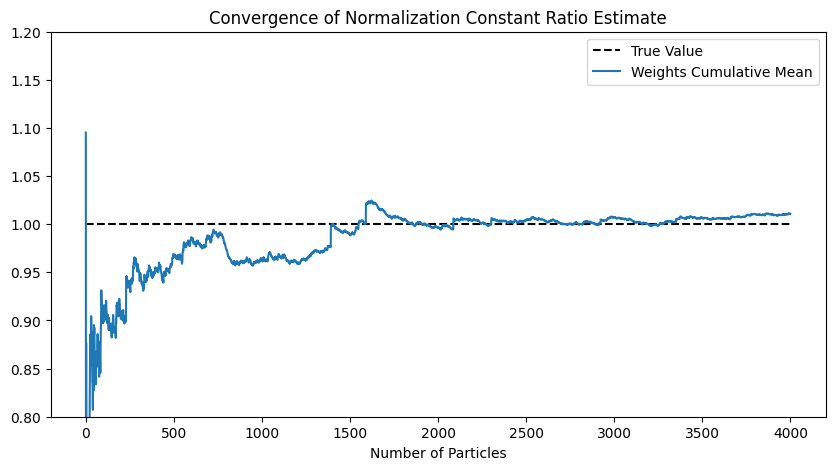

In [218]:
n_range = torch.arange(n_particles)
weights_cummean = log_weights.exp().cumsum(dim=0) / n_range
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.hlines(1, 1, n_particles, linestyle='--', color='black', label='True Value')
ax.plot(n_range, weights_cummean, label='Weights Cumulative Mean')
ax.set_ylim(0.8, 1.2)
ax.set_xlabel('Number of Particles')
ax.legend()
ax.set_title('Convergence of Normalization Constant Ratio Estimate');

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


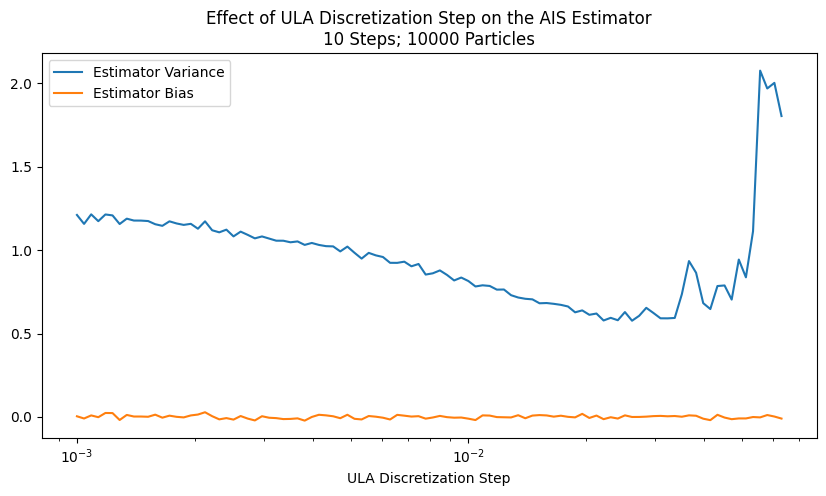

In [227]:
# ULA parameters
time_step_options = np.logspace(-3, -1.2, 100)
# AIS parameters
n_steps = 10
n_particles = 10000

test_logs = defaultdict(list)
for time_step in tqdm(time_step_options):
    transition_kernel = lambda distr: ULAKernel(distr, time_step)
    log_weights, target_samples = run_annealed_importance_sampling(proposal, target, n_steps, n_particles, transition_kernel)
    weights = log_weights.exp()
    test_logs['variance'].append(torch.var(weights))
    test_logs['bias'].append(torch.mean(weights) - 1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_step_options, test_logs['variance'], label='Estimator Variance')
ax.plot(time_step_options, test_logs['bias'], label='Estimator Bias')
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('ULA Discretization Step')
ax.legend()
ax.set_title(f'Effect of ULA Discretization Step on the AIS Estimator\n{n_steps} Steps; {n_particles} Particles');